### Part4: Coincidence detection with AMPA-like and NMDA-like synapses

Coincidence detection can be emulated on Dynap-SE1 by combining the AMPA-like (DPI fast) and the NMDA-like (DPI slow) synapse.

Let's start with importing Brian2:

In [2]:
from brian2 import *
from DynapSE import DynapSE
from parameters.constants import *

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from parameters.set_params import set_params

# Display plots inside Jupyter cell
%matplotlib inline 
# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90 
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

from equations.dynapse_eq import *
from parameters.dynapse_param import *

# Ignore Brian2 base warnings
BrianLogger.suppress_name('base')
# The clock of Brian2 simulation for numerically solve ODEs
defaultclock.dt = 20 * us

### Input Spike Train

Let's generate a Spike Train with N=num_spikes spikes*2, which consists of two spike trains:
- input pulses via the **AMPA** synapse: regular spike train with rate=2Hz 
- input pulses via the **NMDA** synapse: generated from the first spike train, by regularly shifting the i-th spike with respect to the i-th AMPA spike by 10ms*i.

Run the next cell to visualize the resulting input spike train:

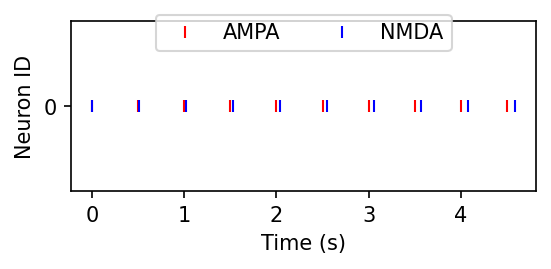

In [3]:
num_spikes = 10
rate = 2            # Hz
inp_duration = num_spikes/rate # second
spikes = np.zeros(int(inp_duration*1000))
dt = int(1000/rate)
end = int(inp_duration*1000)
spikes[0:end:dt] = 1.0

spike_timing_ampa = np.where(spikes==1)[0] * ms # Timing of spikes
spike_timing_nmda = np.array([spike_timing_ampa[idx]/ms+idx*10 for idx in range(len(spike_timing_ampa))])*ms

neuron_indices_nmda = np.zeros(len(spike_timing_nmda)) # ID of spike sources
neuron_indices_ampa = np.zeros(len(spike_timing_ampa)) # ID of spike sources

# Spike Generator
input_spike_generator_ampa = SpikeGeneratorGroup(1, indices=neuron_indices_ampa, times=spike_timing_ampa, name='InpAMPA')  
input_spike_generator_nmda = SpikeGeneratorGroup(1, indices=neuron_indices_nmda, times=spike_timing_nmda, name='InpNMDA')  

# Plot
plt.figure(figsize=(4,1.5),dpi=150)
plt.plot(spike_timing_ampa, neuron_indices_ampa, 'r|', label='AMPA')
plt.plot(spike_timing_nmda, neuron_indices_nmda, 'b|', label='NMDA')
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.1))
plt.xlabel("Time (s)")
plt.ylabel("Neuron ID")
plt.ylim(-0.25, .25)
plt.yticks([0])
plt.show()

### Brian2 Network

In [4]:
network = Network() # Instantiate a Brian2 Network
chip = DynapSE(network) # Instantiate a Dynap-SE1 chip implementing neural and synaptic silicon dynamics

# Overwrite default pameters:
dynapse_param['I_wo_syn_nmda'] = 5 * nA
dynapse_param['I_wo_syn_ampa'] = 20 * nA

dynapse_param['Itau'] = 5 *pA
dynapse_param['Ith'] = dynapse_param['Itau']
dynapse_param["Ispkthr"] = 1 *nA

dynapse_param["I_tau_syn_nmda"] = 1 *pA
dynapse_param["I_tau_syn_ampa"] = 10 *pA

dynapse_param["I_g_syn_nmda"] = .5 * dynapse_param["I_tau_syn_nmda"]
dynapse_param["I_g_syn_ampa"] = 1 * dynapse_param["I_tau_syn_ampa"]

dynapse_param["Vnmda"] = 280*mV

for core in chip.cores:
    set_params(core.neurons, dynapse_param)

Now we will connect our spike generator groups to one target neuron, via one AMPA-like and one NMDA-like DPI circuit. 

In [5]:
DPI_neuron  = chip.get_neurons(1, 'Core_1') # Allocate single DPI neuron from Core 1
DPI_AMPA_synapse = chip.add_connection(input_spike_generator_ampa, DPI_neuron, synapse_type='AMPA') # Define a slow excitatory synapse
DPI_NMDA_synapse = chip.add_connection(input_spike_generator_nmda, DPI_neuron, synapse_type='NMDA') # Define a fast excitatory synapse

# In Brian2 creating Synapses instance does not connect two endpoints, it only specifies synaptic dynamics 
# Let's connect two endpoints and set an initial weight of 300.

chip.connect(DPI_NMDA_synapse, True)
DPI_NMDA_synapse.weight=1
chip.connect(DPI_AMPA_synapse, True)
DPI_AMPA_synapse.weight=1

1 neurons are allocated from Core_1.


### Run simulation

In [6]:
# Monitors
mon_neuron_input_ampa  = SpikeMonitor(input_spike_generator_ampa, name='mon_neuron_input_ampa')
mon_neuron_input_nmda  = SpikeMonitor(input_spike_generator_nmda, name='mon_neuron_input_nmda')
mon_synapse_nmda  = StateMonitor(DPI_NMDA_synapse, 'I_syn_nmda', record=[0])
mon_synapse_ampa  = StateMonitor(DPI_AMPA_synapse, 'I_syn_ampa', record=[0])
mon_neuron_state  = StateMonitor(DPI_neuron, 'Imem', record=True)
mon_neuron_vmem  = StateMonitor(DPI_neuron, 'Vmem', record=True)
mon_neuron_I_syn_nmda  = StateMonitor(DPI_NMDA_synapse, 'I_syn_nmda_dp_clip', record=True)
mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')

# Add every instance we created to Brian network, so it will include them in the simulation
network.add([input_spike_generator_ampa, input_spike_generator_nmda, DPI_neuron, DPI_NMDA_synapse, 
             DPI_AMPA_synapse, mon_neuron_input_ampa, mon_neuron_input_nmda, mon_synapse_nmda, 
             mon_synapse_ampa, mon_neuron_output, mon_neuron_state, mon_neuron_vmem, mon_neuron_I_syn_nmda])

# Simulation
duration = 2 * 1000 * ms

# Run
# store network state before run
network.store()
network.run(duration)

WARNING    "Ut" is an internal variable of group "Core_0", but also exists in the run namespace with the value 25. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Io" is an internal variable of group "Core_0", but also exists in the run namespace with the value 0.5 * pamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Ut" is an internal variable of group "Core_1", but also exists in the run namespace with the value 25. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Io" is an internal variable of group "Core_1", but also exists in the run namespace with the value 0.5 * pamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Ut" is an internal variable of group "Core_2", but also exists in the run namespace with the value 25. * mvolt. The internal v

## Print parameters

#### Time constants:

In [7]:
print('I_tau_syn AMPA: {}'.format(DPI_AMPA_synapse.I_tau_syn_ampa))
print('I_tau_syn NMDA: {}'.format(DPI_NMDA_synapse.I_tau_syn_nmda))

kappa = (kappa_n + kappa_n) / 2
tau_ampa = DPI_AMPA_synapse.C_syn_ampa * Ut /(kappa_p * DPI_AMPA_synapse.I_tau_syn_ampa)
tau_nmda = DPI_NMDA_synapse.C_syn_nmda * Ut /(kappa_p * DPI_NMDA_synapse.I_tau_syn_nmda)
tau = (DPI_neuron.Cmem * Ut) / (kappa * DPI_neuron.Itau)

print('Tau AMPA: {}'.format(tau_ampa))
print('Tau NMDA: {}'.format(tau_nmda))
print('Tau neuron: {} sec'.format(tau))

I_tau_syn AMPA: <AMPA0.I_tau_syn_ampa: array([10.]) * pamp>
I_tau_syn NMDA: <NMDA1.I_tau_syn_nmda: array([1.]) * pamp>
Tau AMPA: [5.68181818] ms
Tau NMDA: [56.81818182] ms
Tau neuron: 0.010000000000000002 sec


Notice that the neuron and the synapse leakage were set such that:

$$ \tau_{AMPA} <\tau < \tau_{NMDA}$$

#### Amplitude EPSC

Let's check the amplitude of the EPSC.

At t=0: $V_{mem}$=0, $I_{syn,nmda}$=$I_o$, and the EPSC amplitude is:

$$ I_{syn_0} = \frac{I_{w}I_{g} \cdot w}{ I_{tau}  ( \frac{I_g}{I_{syn,nmda}} + 1 ) } = \frac{I_{w}I_{g} \cdot w}{ I_{tau}  ( \frac{I_g}{Io} + 1 ) } $$

After the first spike, if the Vmem does not decay to zero and $I_{syn,nmda}$>>$Io$, the EPSC amplitude becomes:

$$ I_{syn_0} = \frac{I_{w}I_{g} \cdot w}{ I_{tau} } $$

In our simulation:

In [8]:
EPSC_t0 = DPI_NMDA_synapse.I_wo_syn_nmda*DPI_NMDA_synapse.weight*DPI_NMDA_synapse.I_g_syn_nmda/(DPI_NMDA_synapse.I_tau_syn_nmda*((DPI_NMDA_synapse.I_g_syn_nmda/Io)+1))
print('EPSC NMDA Amplitude @t=0:', EPSC_t0)

EPSC_t = DPI_NMDA_synapse.I_wo_syn_nmda * DPI_NMDA_synapse.weight*DPI_NMDA_synapse.I_g_syn_nmda/ DPI_NMDA_synapse.I_tau_syn_nmda
print('EPSC NMDA Amplitude @t>0 (and I_syn >> Io):', EPSC_t)

EPSC NMDA Amplitude @t=0: [1.25] nA
EPSC NMDA Amplitude @t>0 (and I_syn >> Io): [2.5] nA


In [9]:
EPSC_t0_ampa = DPI_AMPA_synapse.I_wo_syn_ampa*DPI_AMPA_synapse.weight*DPI_AMPA_synapse.I_g_syn_ampa/(DPI_AMPA_synapse.I_tau_syn_ampa*((DPI_AMPA_synapse.I_g_syn_ampa/Io)+1))
print('EPSC AMPA Amplitude:', EPSC_t0_ampa)

EPSC AMPA Amplitude: [0.95238095] nA


### Plot results

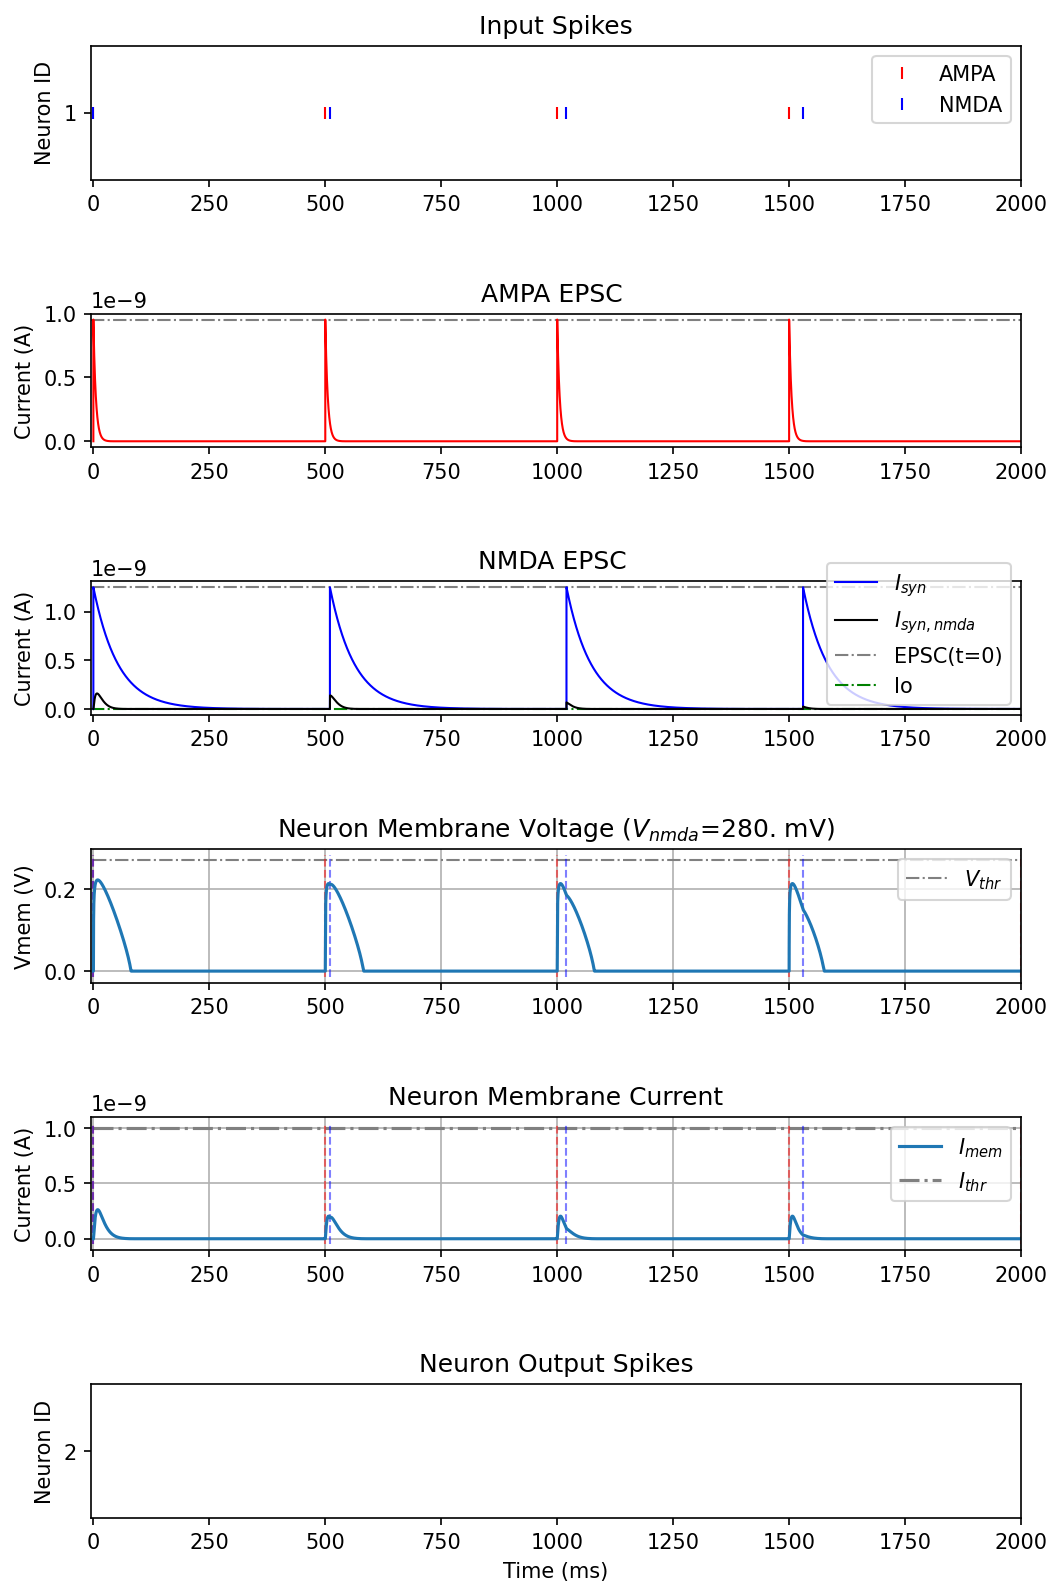

In [10]:
f = plt.figure(figsize=(8,13),dpi=150)
plt.subplots_adjust(hspace=1)
tstart = 0
tend   = int(duration*1000) # ms
Vthr = Ut/DPI_neuron.kappa*log(dynapse_param['Ispkthr']/Io)

# Input Spikes 
plt.subplot(611)
spike_placeholder = np.zeros(5000)
spike_placeholder[np.array(mon_neuron_input_ampa.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'r|', label='AMPA')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
spike_placeholder = np.zeros(5000)
spike_placeholder[np.array(mon_neuron_input_nmda.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'b|', label='NMDA')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
plt.legend()
plt.title('Input Spikes')
plt.ylabel('Neuron ID')
plt.xlim(-5, duration/ms)
#plt.xlabel('Time (ms)')

plt.subplot(612)
s = int(1*ms / defaultclock.dt)
plt.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_synapse_ampa.I_syn_ampa[0][tstart*s:tend*s], linewidth=1, c='r')
plt.hlines(y=EPSC_t0_ampa[0]+Io, xmin=-5, xmax=duration/ms, color='grey', linestyles='-.', label='EPSC', linewidth=1)
plt.xlim(-5, duration/ms)
plt.ylabel('Current (A)')
plt.title('AMPA EPSC ')

plt.subplot(613)
s = int(1*ms / defaultclock.dt)
plt.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_synapse_nmda.I_syn_nmda[0][tstart*s:tend*s], linewidth=1, label='$I_{syn}$', c='b')
plt.plot(mon_neuron_I_syn_nmda.t[tstart*s:tend*s]/ms, mon_neuron_I_syn_nmda.I_syn_nmda_dp_clip[0][tstart*s:tend*s], linewidth=1, c='k', label='$I_{syn,nmda}$')
plt.hlines(y=EPSC_t0[0]+Io, xmin=-5, xmax=duration/ms, color='grey', linestyles='-.', label='EPSC(t=0)', linewidth=1)
plt.hlines(y=Io, xmin=-5, xmax=duration/ms, color='green', linestyles='-.', label='Io', linewidth=1)
plt.legend()
plt.xlim(-5, duration/ms)
plt.ylabel('Current (A)')
plt.title('NMDA EPSC ')

plt.subplot(614)
plt.hlines(y=Vthr, xmin=0, xmax=duration/ms, color='grey', linestyles='-.', linewidth=1, label='$V_{thr}$')
plt.legend()
plt.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_neuron_vmem.Vmem[0][tstart*s:tend*s], linewidth=1.5)
ylim = plt.ylim()
plt.vlines(spike_timing_ampa.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='r', alpha=.5, linewidth=1)
plt.vlines(spike_timing_nmda.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='b', alpha=.5, linewidth=1)
plt.title('Neuron Membrane Voltage ($V_{nmda}$='+str(dynapse_param["Vnmda"])+')')
plt.ylabel('Vmem (V)')
plt.xlim(-5, duration/ms)
plt.grid(True)

plt.subplot(615)
Imem = mon_neuron_state.Imem[0]
plt.plot(mon_neuron_state.t/ms, Imem)
plt.hlines(y=dynapse_param['Ispkthr']*1e-9/nA, xmin=tstart, xmax=tend, color='grey', linestyles='-.')
plt.legend(['$I_{mem}$', '$I_{thr}$'])
plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
plt.xlim(-5, duration/ms)
ylim = plt.ylim()
plt.vlines(spike_timing_ampa.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='r', alpha=.5, linewidth=1)
plt.vlines(spike_timing_nmda.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='b', alpha=.5, linewidth=1)
plt.grid(True)

plt.subplot(616)
spike_placeholder = np.zeros(5000)
spike_placeholder[np.array(mon_neuron_output.t/ms, dtype=int)]=2
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(1.5, 2.5)
plt.title('Neuron Output Spikes')
plt.ylabel('Neuron ID')
plt.xlabel('Time (ms)')
plt.xlim(-5, duration/ms)
plt.show()

f.savefig('./DPI_coincidenceDetection_'+str(np.array(DPI_NMDA_synapse.Vnmda)[0])+'.pdf')

# Sweep Vnmda

In [11]:
output_spikes = {}

network.restore()
vmem = {}
imem = {}
inmda = {}
out_spikes = {}
# Sweep V_nmda threshold values:
range_nmda = np.linspace(150, Vthr/mV, 6).astype(int)
for vnmda in range_nmda:
    print(vnmda)
    dynapse_param['Vnmda'] = vnmda*mV
        
    for core in chip.cores:
        set_params(core.neurons, dynapse_param)
        
    # Simulation
    duration = inp_duration * 1000 * ms

    # Run
    network.run(duration)
    
    inmda[vnmda] = (mon_neuron_I_syn_nmda.t/ms, mon_neuron_I_syn_nmda.I_syn_nmda_dp_clip[0])
    imem[vnmda] = (mon_neuron_state.t/ms, mon_neuron_state.Imem[0])
    vmem[vnmda] = (mon_neuron_vmem.t/ms, mon_neuron_vmem.Vmem[0])
    out_spikes[vnmda] = mon_neuron_output.t/ms
    
    network.restore()

WARNING    "Imem" is an internal variable of group "Core_0", but also exists in the run namespace with the value array([0.00000000e+00, 4.70105664e-02, 8.96484540e+01, ...,
       4.21853887e+02, 4.21880971e+02, 4.21908047e+02]) * famp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Imem" is an internal variable of group "Core_1", but also exists in the run namespace with the value array([0.00000000e+00, 4.70105664e-02, 8.96484540e+01, ...,
       4.21853887e+02, 4.21880971e+02, 4.21908047e+02]) * famp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Imem" is an internal variable of group "Core_2", but also exists in the run namespace with the value array([0.00000000e+00, 4.70105664e-02, 8.96484540e+01, ...,
       4.21853887e+02, 4.21880971e+02, 4.21908047e+02]) * famp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "I

150
173
197
221
245
269


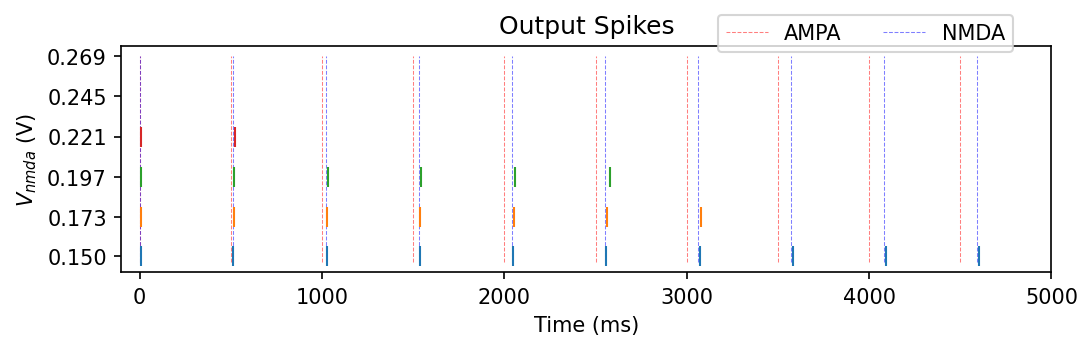

In [12]:
f = plt.figure(figsize=(8,2),dpi=150)
plt.subplot(111)
for i, vnmda in enumerate(range_nmda):
    spike_times = out_spikes[vnmda]
    plt.plot(spike_times, [vnmda*mV]*len(spike_times), '|', c=colors[i], markersize=10)
plt.yticks(range_nmda*1e-3)
plt.xlim(-100, duration/ms)
plt.xlabel('Time (ms)')
plt.ylabel('$V_{nmda}$ (V)')
plt.title('Output Spikes')
ylim = plt.ylim()
plt.vlines(spike_timing_ampa.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='r', alpha=.5, linewidth=.5, label='AMPA')
plt.vlines(spike_timing_nmda.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='b', alpha=.5, linewidth=.5, label='NMDA')
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.8, 1.18))